In [1]:
## DESCRIPTION
# meteo_precipitation_AA_cells_rea11_kr11
# meteo_precipitation_AA_monthly_cells_boxplot_kr11-rea11

In [2]:
import sys

lib_dir = "/home/daniele/documents/github/ftt01/phd/share/lib"
sys.path.insert( 0, lib_dir )

In [3]:
from lib import *

In [4]:
wdir = "/home/daniele/documents/github/ftt01/phd/projects/era5_evaluation/"
current = DataCollector(configPath=wdir + "etc/conf/")

In [5]:
## SETUP
basin = 'AA'
# for output name
basin_str = 'alto_adige'

start_date_str = "2010-01-01T00:00:00"
end_date_str = "2019-12-31T23:00:00"
start_date = dt.datetime.strptime( start_date_str, '%Y-%m-%dT%H:%M:%S' )
end_date = dt.datetime.strptime( end_date_str, '%Y-%m-%dT%H:%M:%S' )

In [6]:
## REANALYSIS DATASET ##
precipitation_rea_path = "/media/lacie2022/data/GFS_models/ECMWF/ERA5Land-reanalysis/derivatives/ptot/hourly_ts/"

# to consider only AA cells 
list_of_cells = []

precipitation_df_rea = pd.DataFrame()
precipitation_box_rea = pd.DataFrame()

p_file_tot = glob.glob( precipitation_rea_path + '*.csv' )

for p_file in p_file_tot:
    data_tot = pd.read_csv( p_file, header=0, index_col=0, \
        skiprows=4, parse_dates=True, names=[ os.path.basename(p_file)[:-4] ])
    data_tot = data_tot[start_date:end_date]
    data_tot[data_tot == -999] = None
    precipitation_df_rea = pd.concat([precipitation_df_rea, data_tot],axis=1)
    list_of_cells.append(os.path.basename(p_file)[:-4])

# # spatial mean over all cells
# precipitation_rea_spatial_mean = precipitation_df_rea.sum(axis=1)

# # temporal mean over all cells
# precipitation_rea_temporal_mean = precipitation_df_rea.mean(axis=0)
# # temporal ECDF
# precipitation_rea_temporal_ecdf = evaluateECDF( precipitation_rea_temporal_mean )

In [7]:
## KRIGING 11X8 DATASET ##
precipitation_kr11_path = "/media/windows/projects/era5_bias/kriging/old/kriging/AltoAdige/P/"
    
precipitation_df_kr11 = pd.DataFrame()
precipitation_box_kr11 = pd.DataFrame()

p_file_tot = glob.glob( precipitation_kr11_path + '*.csv' )

for p_file in p_file_tot:
    if os.path.basename(p_file)[:-4] in list_of_cells:
        data_tot = pd.read_csv( p_file, header=0, index_col=0, \
            skiprows=4, parse_dates=True, names=[ os.path.basename(p_file)[:-4] ])
        data_tot = data_tot[start_date:end_date]
        data_tot[data_tot == -999] = None
        precipitation_df_kr11 = pd.concat([precipitation_df_kr11, data_tot],axis=1)

# # spatial mean over all cells
# precipitation_kr11_spatial_mean = precipitation_df_kr11.sum(axis=1)

# # temporal mean over all cells
# precipitation_kr11_temporal_mean = precipitation_df_kr11.mean(axis=0)
# # temporal ECDF
# precipitation_kr11_temporal_ecdf = evaluateECDF( precipitation_kr11_temporal_mean )

In [8]:
# spatial mean over all cells
precipitation_rea_spatial_mean = precipitation_df_rea.mean(axis=1)
# spatial mean over all cells
precipitation_kr11_spatial_mean = precipitation_df_kr11.mean(axis=1)

In [9]:
#### statistics over cells
### precipitation yearly aggregated
precipitation_df_rea_yearly_sum = precipitation_df_rea.resample('Y').sum()
precipitation_df_kr11_yearly_sum = precipitation_df_kr11.resample('Y').sum()
## difference between datasets for each cell 
precipitation_bias_yearly = precipitation_df_rea_yearly_sum - precipitation_df_kr11_yearly_sum

### precipitation bias mean for each year - spatial mean
# print( precipitation_bias_yearly.mean(axis=1).describe() )

### precipitation bias mean for each cell - temporal mean
## OLD ##
# pathout = "/media/windows/projects/era5_bias/OLD/comparison/basin_comparison/"
# diff_p_elev = pd.read_csv(pathout+'diff_media_temporale_ptot.csv',index_col=0)
# diff_t_elev = pd.read_csv(pathout+'diff_media_temporale_t2m.csv',index_col=0)
## plotted in QGIS as diff_ptot
print( precipitation_bias_yearly.mean(axis=0).describe() )

count    102.000000
mean     364.739745
std      181.593303
min       27.043800
25%      228.439550
50%      346.636400
75%      467.469675
max      914.957700
dtype: float64


In [10]:
### extrapolation of data to build the maps
## 1. extraction of the grid 11x8km
## 2. temporal mean over the entire dataset - mean of all years over each cell

pathout = "/media/windows/projects/era5_bias/OLD/comparison/basin_comparison/"
diff_t_elev = pd.read_csv(pathout+'diff_media_temporale_ptot.csv',index_col=0)
diff_t_elev.drop('12', axis=1, inplace=True)
diff_t_elev.drop(169, inplace=True)

grid_11_8_coordinates = diff_t_elev

## yearly temporal mean bias
data = grid_11_8_coordinates
bias = []
for id in grid_11_8_coordinates.index:
    # print(id)
    bias.append( precipitation_bias_yearly.mean(axis=0)[str(id)] )

data['bias'] = bias

output_dir = current.config["output_path"] + "meteo/" + basin_str + "/precipitation/" + "/yearly/"
mkNestedDir( output_dir )
data.to_csv( output_dir + "meteo_precipitation_" + basin_str + "_yearly_temporal_mean_cells" + ".csv" )

In [11]:
precipitation_bias = precipitation_df_rea - precipitation_df_kr11

## seasonal temporal sum bias
data = grid_11_8_coordinates

precipitation_bias_jan = precipitation_bias.loc[(precipitation_bias.index.month==1)]
precipitation_bias_feb = precipitation_bias.loc[(precipitation_bias.index.month==2)]
precipitation_bias_mar = precipitation_bias.loc[(precipitation_bias.index.month==3)]
precipitation_bias_apr = precipitation_bias.loc[(precipitation_bias.index.month==4)]
precipitation_bias_may = precipitation_bias.loc[(precipitation_bias.index.month==5)]
precipitation_bias_jun = precipitation_bias.loc[(precipitation_bias.index.month==6)]
precipitation_bias_jul = precipitation_bias.loc[(precipitation_bias.index.month==7)]
precipitation_bias_aug = precipitation_bias.loc[(precipitation_bias.index.month==8)]
precipitation_bias_sep = precipitation_bias.loc[(precipitation_bias.index.month==9)]
precipitation_bias_oct = precipitation_bias.loc[(precipitation_bias.index.month==10)]
precipitation_bias_nov = precipitation_bias.loc[(precipitation_bias.index.month==11)]
precipitation_bias_dec = precipitation_bias.loc[(precipitation_bias.index.month==12)]

number_of_years = len( precipitation_bias.resample('Y').sum() )

precipitation_bias_w=pd.concat( [precipitation_bias_dec,precipitation_bias_jan,precipitation_bias_feb] ).sum(axis=0) / number_of_years
precipitation_bias_sp=pd.concat( [precipitation_bias_mar,precipitation_bias_apr,precipitation_bias_may] ).sum(axis=0) / number_of_years
precipitation_bias_su=pd.concat( [precipitation_bias_jun,precipitation_bias_jul,precipitation_bias_aug] ).sum(axis=0) / number_of_years
precipitation_bias_a=pd.concat( [precipitation_bias_sep,precipitation_bias_oct,precipitation_bias_nov] ).sum(axis=0) / number_of_years

data['bias_w'] = precipitation_bias_w.values
data['bias_sp'] = precipitation_bias_sp.values
data['bias_su'] = precipitation_bias_su.values
data['bias_a'] = precipitation_bias_a.values

output_dir = current.config["output_path"] + "meteo/" + basin_str + "/precipitation/" + "/monthly/"
mkNestedDir( output_dir )
data.to_csv( output_dir + "meteo_precipitation_" + basin_str + "_seasonal_temporal_sum_cells" + ".csv" )

In [12]:
data.describe()

,east,north,z,bias,bias_w,bias_sp,bias_su,bias_a
count,102.000000,1.020000e+02,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,684052.009804,5.176746e+06,1894.168283,364.739745,90.873604,102.851407,108.693318,62.321417
std,40985.988409,1.939506e+04,395.257183,181.593303,23.839492,34.029375,109.675179,37.818967
min,604214.500000,5.133712e+06,834.885081,27.043800,52.910000,42.300200,-78.087800,-2.057200
25%,652320.750000,5.166308e+06,1663.965348,228.439550,73.859025,82.258300,18.255125,35.005475
50%,688881.500000,5.177172e+06,1880.298143,346.636400,86.532250,97.899500,91.560150,58.663250
75%,719669.500000,5.188038e+06,2123.500460,467.469675,104.486725,117.273625,179.436975,83.760825
max,750457.500000,5.220632e+06,2871.462302,914.957700,166.558400,218.586300,404.374200,180.676400


In [13]:
# boxplot monthly bias
precipitation_bias = precipitation_rea_spatial_mean - precipitation_kr11_spatial_mean
precipitation_bias_monthly_sum = precipitation_bias.resample('MS').sum()

output_path = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/monthly/" + "meteo_precipitation_" + basin_str + "_monthly_spatial_mean_cells_boxplot_rea-kr11." + output_format 
createBoxPlot( precipitation_bias_monthly_sum,  "Time $[month]$", 'Prec. bias $[mm/month]$', \
    output_path, label="(b)", period='MS', output_format=output_format, scale_factor=0.65, my_dpi=50 )

output_path_hd = current.config["output_path"] + "meteo/" + basin_str + "/precipitation/" + "/monthly/" + "meteo_precipitation_" + basin_str + "_monthly_spatial_mean_cells_boxplot_rea-kr11_HD." + output_format 
createBoxPlot( precipitation_bias_monthly_sum,  "Time $[month]$", 'Prec. bias $[mm/month]$', \
    output_path_hd, label="(b)", period='MS', output_format=output_format, scale_factor=0.65, my_dpi=600)

In [14]:
## statistics on monthly data
precipitation_bias = precipitation_rea_spatial_mean - precipitation_kr11_spatial_mean
precipitation_bias_monthly_sum = precipitation_bias.resample('MS').sum()

#-------------------boxplot seasonal--------------------     
precipitation_bias_monthly_sum_jan=precipitation_bias_monthly_sum.loc[(precipitation_bias_monthly_sum.index.month==1)]
precipitation_bias_monthly_sum_feb=precipitation_bias_monthly_sum.loc[(precipitation_bias_monthly_sum.index.month==2)]
precipitation_bias_monthly_sum_mar=precipitation_bias_monthly_sum.loc[(precipitation_bias_monthly_sum.index.month==3)]
precipitation_bias_monthly_sum_apr=precipitation_bias_monthly_sum.loc[(precipitation_bias_monthly_sum.index.month==4)]
precipitation_bias_monthly_sum_may=precipitation_bias_monthly_sum.loc[(precipitation_bias_monthly_sum.index.month==5)]
precipitation_bias_monthly_sum_jun=precipitation_bias_monthly_sum.loc[(precipitation_bias_monthly_sum.index.month==6)]
precipitation_bias_monthly_sum_jul=precipitation_bias_monthly_sum.loc[(precipitation_bias_monthly_sum.index.month==7)]
precipitation_bias_monthly_sum_aug=precipitation_bias_monthly_sum.loc[(precipitation_bias_monthly_sum.index.month==8)]
precipitation_bias_monthly_sum_sep=precipitation_bias_monthly_sum.loc[(precipitation_bias_monthly_sum.index.month==9)]
precipitation_bias_monthly_sum_oct=precipitation_bias_monthly_sum.loc[(precipitation_bias_monthly_sum.index.month==10)]
precipitation_bias_monthly_sum_nov=precipitation_bias_monthly_sum.loc[(precipitation_bias_monthly_sum.index.month==11)]
precipitation_bias_monthly_sum_dec=precipitation_bias_monthly_sum.loc[(precipitation_bias_monthly_sum.index.month==12)]

# print( precipitation_bias_monthly_sum_jan.describe() )
# print( precipitation_bias_monthly_sum_feb.describe() )
# print( precipitation_bias_monthly_sum_mar.describe() )
# print( precipitation_bias_monthly_sum_apr.describe() )
# print( precipitation_bias_monthly_sum_may.describe() )
# print( precipitation_bias_monthly_sum_jun.describe() )
# print( precipitation_bias_monthly_sum_jul.describe() )
# print( precipitation_bias_monthly_sum_aug.describe() )
# print( precipitation_bias_monthly_sum_sep.describe() )
# print( precipitation_bias_monthly_sum_oct.describe() )
# print( precipitation_bias_monthly_sum_nov.describe() )
# print( precipitation_bias_monthly_sum_dec.describe() )
##
print( precipitation_bias_monthly_sum.describe() )

count    120.000000
mean      30.394979
std       18.197884
min      -32.114618
25%       19.671324
50%       28.628314
75%       41.036934
max       76.265745
dtype: float64


In [15]:
# boxplot hourly bias
precipitation_bias = precipitation_rea_spatial_mean - precipitation_kr11_spatial_mean

output_path = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/hourly/" + "meteo_precipitation_" + basin_str + "_hourly_spatial_mean_cells_boxplot_rea-kr11." + output_format 
createBoxPlot( precipitation_bias,  "Time $[hour]$", "Prec. bias $[mm/hour]$", \
    output_path, period='MS', output_format=output_format, my_dpi=50 )

output_path_hd = current.config["output_path"] + "meteo/" + basin_str + "/precipitation/" + "/hourly/" + "meteo_precipitation_" + basin_str + "_hourly_spatial_mean_cells_boxplot_rea-kr11_HD." + output_format 
createBoxPlot( precipitation_bias,  "Time $[hour]$", "Prec. bias $[mm/hour]$", \
    output_path_hd, period='MS', output_format=output_format, my_dpi=600)

In [16]:
# spatial ECDF - hourly
precipitation_rea_spatial_ecdf = evaluateECDF( precipitation_rea_spatial_mean )
precipitation_kr11_spatial_ecdf = evaluateECDF( precipitation_kr11_spatial_mean )

precipitation_rea_spatial_ecdf_mod = precipitation_rea_spatial_ecdf
precipitation_rea_spatial_ecdf_mod[precipitation_rea_spatial_ecdf<=0.005] = None
precipitation_rea_spatial_ecdf_mod.dropna(inplace=True)
precipitation_kr11_spatial_ecdf_mod = precipitation_kr11_spatial_ecdf
precipitation_kr11_spatial_ecdf_mod[precipitation_kr11_spatial_ecdf<=0.005] = None
precipitation_kr11_spatial_ecdf_mod.dropna(inplace=True)

plots = []

### rea 11x8 plot ###
plt_conf = {}
plt_conf["label"] = 'REA11x8'
plt_conf["color"] = '#e66101'
plots.append( (precipitation_rea_spatial_ecdf_mod, plt_conf) )

### kriging 11x8 plot ###
plt_conf = {}
plt_conf["label"] = 'KR11x8'
plt_conf["color"] = '#5e3c99'
plots.append( (precipitation_kr11_spatial_ecdf_mod, plt_conf) )

output_file = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/hourly/meteo_" + 'precipitation_AA_hourly_spatialECDF.' + output_format
createPlot( plots, "Precipitation $[mm/hour]$", "ECDF", output_file, scale_factor=0.5, my_dpi=50 )

output_file_hd = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/hourly/meteo_" + 'precipitation_AA_hourly_spatialECDF_HD.' + output_format
createPlot( plots, "Precipitation $[mm/hour]$", "ECDF", output_file_hd, scale_factor=0.5, my_dpi=600 )

########################

### to switch the axes
precipitation_rea_spatial_ecdf_mod = precipitation_rea_spatial_ecdf_mod.reset_index().set_index('cdf')
precipitation_kr11_spatial_ecdf_mod = precipitation_kr11_spatial_ecdf_mod.reset_index().set_index('cdf')

output_file = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/hourly/meteo_" + 'precipitation_AA_hourly_spatialECDF_log.' + output_format
createPlot( plots, "Precipitation $[mm/hour]$", "ECDF", output_file, yscale='log', height=160, scale_factor=0.35, my_dpi=50 )

output_file_hd = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/hourly/meteo_" + 'precipitation_AA_hourly_spatialECDF_log_HD.' + output_format
createPlot( plots, "Precipitation $[mm/hour]$", "ECDF", output_file_hd, yscale='log', height=160, scale_factor=0.35, my_dpi=600 )

In [17]:
# exceedance probability plot - hourly
precipitation_rea_fd_mod = precipitation_rea_spatial_mean
precipitation_rea_fd_mod[precipitation_rea_fd_mod<=0.01] = 0
precipitation_rea_fd_mod.dropna(inplace=True)

precipitation_kr11_fd_mod = precipitation_kr11_spatial_mean
precipitation_kr11_fd_mod[precipitation_kr11_fd_mod<=0.01] = 0
precipitation_kr11_fd_mod.dropna(inplace=True)

precipitation_rea_spatial_fd = flowDuration( precipitation_rea_fd_mod )
precipitation_kr11_spatial_fd = flowDuration( precipitation_kr11_fd_mod )

plots = []

### kriging 11x8 plot ###
plt_conf = {}
plt_conf["label"] = 'KR11x8'
plt_conf["color"] = '#5e3c99'
# plt_conf["marker"] = 'o'
plots.append( (precipitation_kr11_spatial_fd, plt_conf) )

### rea 11x8 plot ###
plt_conf = {}
plt_conf["label"] = 'REA11x8'
plt_conf["color"] = '#e66101'
# plt_conf["marker"] = 'o'
plots.append( (precipitation_rea_spatial_fd, plt_conf) )

from matplotlib.ticker import FormatStrFormatter
# y_major_locator=FormatStrFormatter('%.2f')
y_major_locator=None

output_file = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/hourly/meteo_" + 'precipitation_AA_hourly_spatialFD_log.' + output_format
createPlot( plots, "Exceedance Probability", "Prec. $[mm/hour]$", output_file, xticks=[0,10,20,30,40,50,60,70,80,90,100], x_rot=90, \
label="(a)", y_major_formatter=y_major_locator, yscale='log', y_lim_min=0.01, y_lim_max=15, \
    height=160, scale_factor=0.35, bbox_to_anchor=None, my_dpi=50)

output_file_hd = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/hourly/meteo_" + 'precipitation_AA_hourly_spatialFD_log_HD.' + output_format
createPlot( plots, "Exceedance Probability", "Prec. $[mm/hour]$", output_file_hd, xticks=[0,10,20,30,40,50,60,70,80,90,100], x_rot=90, \
label="(a)", y_major_formatter=y_major_locator, yscale='log', y_lim_min=0.01, y_lim_max=15, \
    height=160, scale_factor=0.35, bbox_to_anchor=None, my_dpi=600)

#############

output_file = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/hourly/meteo_" + 'precipitation_AA_hourly_spatialFD_symlog.' + output_format
createPlot( plots, "Exceedance Probability", "Prec. $[mm/hour]$", output_file, label="(a)",\
    y_major_formatter=y_major_locator, yscale='symlog', height=160, scale_factor=0.35, bbox_to_anchor=None, my_dpi=50)

output_file_hd = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/hourly/meteo_" + 'precipitation_AA_hourly_spatialFD_symlog_HD.' + output_format
createPlot( plots, "Exceedance Probability", "Prec. $[mm/hour]$", output_file_hd, label="(a)",\
    y_major_formatter=y_major_locator, yscale='symlog', height=160, scale_factor=0.35, bbox_to_anchor=None, my_dpi=600)

############

output_file = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/hourly/meteo_" + 'precipitation_AA_hourly_spatialFD.' + output_format
createPlot( plots, "Exceedance Probability", "Prec. $[mm/hour]$", output_file, label="(a)",\
    y_major_formatter=y_major_locator, height=160, scale_factor=0.35, bbox_to_anchor=None, my_dpi=50)

output_file_hd = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/hourly/meteo_" + 'precipitation_AA_hourly_spatialFD_HD.' + output_format
createPlot( plots, "Exceedance Probability", "Prec. $[mm/hour]$", output_file_hd, label="(a)",\
    y_major_formatter=y_major_locator, height=160, scale_factor=0.35, bbox_to_anchor=None, my_dpi=600)

In [18]:
df = precipitation_rea_spatial_fd
i = 0
for i in range(len(df)):
    if df.iloc[i][0] <= 0.005:
        id_last = i
        print(id_last)
        break

print( id_last / len( df ) )

46879
0.5348614327929079


In [19]:
df = precipitation_kr11_spatial_fd
i = 0
for i in range(len(df)):
    if df.iloc[i][0] <= 0.005:
        id_last = i
        break

print( id_last / len( df ) )

0.3104955103996714


In [20]:
# spatial ECDF - monthly
precipitation_rea_spatial_ecdf = evaluateECDF( precipitation_rea_spatial_mean.resample('MS').sum() )
precipitation_kr11_spatial_ecdf = evaluateECDF( precipitation_kr11_spatial_mean.resample('MS').sum() )

plots = []

### rea 11x8 plot ###
plt_conf = {}
plt_conf["label"] = 'REA11x8'
plt_conf["color"] = '#e66101'
plots.append( (precipitation_rea_spatial_ecdf, plt_conf) )

### kriging 11x8 plot ###
plt_conf = {}
plt_conf["label"] = 'KR11x8'
plt_conf["color"] = '#5e3c99'
plots.append( (precipitation_kr11_spatial_ecdf, plt_conf) )

output_file =  current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/monthly/meteo_" + 'precipitation_AA_monthly_spatialECDF.' + output_format
createPlot( plots, "Precipitation $[mm/month]$", "ECDF", output_file, scale_factor=0.5, my_dpi=50)

output_file_hd =  current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/monthly/meteo_" + 'precipitation_AA_monthly_spatialECDF_HD.' + output_format
createPlot( plots, "Precipitation $[mm/month]$", "ECDF", output_file_hd, scale_factor=0.5, my_dpi=600)

output_file =  current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/monthly/meteo_" + 'precipitation_AA_monthly_spatialECDF_log.' + output_format
createPlot( plots, "Precipitation $[mm/month]$", "ECDF", output_file, xscale='log', scale_factor=0.5, my_dpi=50)

output_file_hd =  current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/monthly/meteo_" + 'precipitation_AA_monthly_spatialECDF_log_HD.' + output_format
createPlot( plots, "Precipitation $[mm/month]$", "ECDF", output_file_hd, xscale='log', scale_factor=0.5, my_dpi=600)

In [21]:
rea = precipitation_rea_spatial_ecdf
kr = precipitation_kr11_spatial_ecdf
bias_min = np.array(rea.loc[(rea['cdf'] <= 5)].index).mean() - np.array(kr.loc[(kr['cdf'] <= 5)].index).mean()
print(bias_min)

13.48918137254902


In [22]:
rea = precipitation_rea_spatial_ecdf
kr = precipitation_kr11_spatial_ecdf
bias_median = np.array(rea.loc[(rea['cdf'] >= 49.5) & (rea['cdf'] <= 50.5)].index).mean() - np.array(kr.loc[(kr['cdf'] >= 49.5) & (kr['cdf'] <= 50.5)].index).mean()
print(bias_median)

29.27792156862745


In [23]:
rea = precipitation_rea_spatial_ecdf
kr = precipitation_kr11_spatial_ecdf
bias_max = np.array(rea.loc[(rea['cdf'] >= 95)].index).mean() - np.array(kr.loc[(kr['cdf'] >= 95)].index).mean()
print(bias_max)

30.27557352941176


In [24]:
# flow duration plot - monthly
precipitation_rea_spatial_fd = flowDuration( precipitation_rea_spatial_mean.resample('MS').sum() )
precipitation_kr11_spatial_fd = flowDuration( precipitation_kr11_spatial_mean.resample('MS').sum() )

plots = []

### rea 11x8 plot ###
plt_conf = {}
plt_conf["label"] = 'REA11x8'
plt_conf["color"] = '#e66101'
plots.append( (precipitation_rea_spatial_fd, plt_conf) )

### kriging 11x8 plot ###
plt_conf = {}
plt_conf["label"] = 'KR11x8'
plt_conf["color"] = '#5e3c99'
plots.append( (precipitation_kr11_spatial_fd, plt_conf) )

from matplotlib.ticker import FormatStrFormatter
# y_major_locator=FormatStrFormatter('%.2f')
y_major_locator=None

output_file = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/monthly/meteo_" + 'precipitation_AA_monthly_spatialFD_log.' + output_format
createPlot( plots, "Exceedance Probability", "Prec. $[mm/month]$", output_file, \
    y_major_formatter=y_major_locator, yscale='log', height=160, scale_factor=0.35, bbox_to_anchor=None, my_dpi=50)

output_file_hd = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/monthly/meteo_" + 'precipitation_AA_monthly_spatialFD_log_HD.' + output_format
createPlot( plots, "Exceedance Probability", "Prec. $[mm/month]$", output_file_hd, \
    y_major_formatter=y_major_locator, yscale='log', height=160, scale_factor=0.35, bbox_to_anchor=None, my_dpi=600)

In [25]:
# flow duration plot - daily
precipitation_rea_spatial_fd = flowDuration( round(precipitation_rea_spatial_mean.resample('d').sum(), 2) )
precipitation_kr11_spatial_fd = flowDuration( round(precipitation_kr11_spatial_mean.resample('d').sum(), 2) )

plots = []

### rea 11x8 plot ###
plt_conf = {}
plt_conf["label"] = 'REA11x8'
plt_conf["color"] = '#e66101'
plots.append( (precipitation_rea_spatial_fd, plt_conf) )

### kriging 11x8 plot ###
plt_conf = {}
plt_conf["label"] = 'KR11x8'
plt_conf["color"] = '#5e3c99'
plots.append( (precipitation_kr11_spatial_fd, plt_conf) )

from matplotlib.ticker import FormatStrFormatter
# y_major_locator=FormatStrFormatter('%.2f')
y_major_locator=None

output_file = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/daily/meteo_" + 'precipitation_AA_daily_spatialFD_log.' + output_format
createPlot( plots, "Exceedance Probability", "Prec. $[mm/day]$", output_file, \
    y_major_formatter=y_major_locator, yscale='log', height=160, scale_factor=0.35, bbox_to_anchor=None, my_dpi=50)

output_file_hd = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/daily/meteo_" + 'precipitation_AA_daily_spatialFD_log_HD.' + output_format
createPlot( plots, "Exceedance Probability", "Prec. $[mm/day]$", output_file_hd, \
    y_major_formatter=y_major_locator, yscale='log', height=160, scale_factor=0.35, bbox_to_anchor=None, my_dpi=600)

In [26]:
precipitation_bias = precipitation_rea_spatial_mean - precipitation_kr11_spatial_mean

#-------------------boxplot seasonal--------------------     
precipitation_bias_jan=precipitation_bias.loc[(precipitation_bias.index.month==1)]
precipitation_bias_feb=precipitation_bias.loc[(precipitation_bias.index.month==2)]
precipitation_bias_mar=precipitation_bias.loc[(precipitation_bias.index.month==3)]
precipitation_bias_apr=precipitation_bias.loc[(precipitation_bias.index.month==4)]
precipitation_bias_may=precipitation_bias.loc[(precipitation_bias.index.month==5)]
precipitation_bias_jun=precipitation_bias.loc[(precipitation_bias.index.month==6)]
precipitation_bias_jul=precipitation_bias.loc[(precipitation_bias.index.month==7)]
precipitation_bias_aug=precipitation_bias.loc[(precipitation_bias.index.month==8)]
precipitation_bias_sep=precipitation_bias.loc[(precipitation_bias.index.month==9)]
precipitation_bias_oct=precipitation_bias.loc[(precipitation_bias.index.month==10)]
precipitation_bias_nov=precipitation_bias.loc[(precipitation_bias.index.month==11)]
precipitation_bias_dec=precipitation_bias.loc[(precipitation_bias.index.month==12)]

precipitation_bias_w=pd.concat([precipitation_bias_jan,precipitation_bias_feb,precipitation_bias_mar])
precipitation_bias_sp=pd.concat([precipitation_bias_apr,precipitation_bias_may,precipitation_bias_jun])
precipitation_bias_su=pd.concat([precipitation_bias_jul,precipitation_bias_aug,precipitation_bias_sep])
precipitation_bias_a=pd.concat([precipitation_bias_oct,precipitation_bias_nov,precipitation_bias_dec])

output_file = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/hourly/seasonal/" + 'meteo_precipitation_' + basin_str + '_hourly_boxplot_spatial_mean_cells_rea-kr11_winter.' + output_format
createBoxPlot( precipitation_bias_w, "Time $[hour]$", "Prec. $[mm/hour]$", \
    output_file, output_format=output_format, period="H", scale_factor=0.5, my_dpi=50 )

output_file_hd = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/hourly/seasonal/" + 'meteo_precipitation_' + basin_str + '_hourly_boxplot_spatial_mean_cells_rea-kr11_winter_HD.' + output_format
createBoxPlot( precipitation_bias_w, "Time $[hour]$", "Prec. $[mm/hour]$", \
    output_file_hd, output_format=output_format, period="H", scale_factor=0.5, my_dpi=600 )

output_file = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/hourly/seasonal/" + 'meteo_precipitation_' + basin_str + '_hourly_boxplot_spatial_mean_cells_rea-kr11_spring.' + output_format
createBoxPlot( precipitation_bias_sp, "Time $[hour]$", "Prec. $[mm/hour]$", \
    output_file, output_format=output_format, period="H", scale_factor=0.5, my_dpi=50 )

output_file_hd = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/hourly/seasonal/" + 'meteo_precipitation_' + basin_str + '_hourly_boxplot_spatial_mean_cells_rea-kr11_spring_HD.' + output_format
createBoxPlot( precipitation_bias_sp, "Time $[hour]$", "Prec. $[mm/hour]$", \
    output_file_hd, output_format=output_format, period="H", scale_factor=0.5, my_dpi=600 )

output_file = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/hourly/seasonal/" + 'meteo_precipitation_' + basin_str + '_hourly_boxplot_spatial_mean_cells_rea-kr11_summer.' + output_format
createBoxPlot( precipitation_bias_su, "Time $[hour]$", "Prec. $[mm/hour]$", \
    output_file, output_format=output_format, period="H", scale_factor=0.5, my_dpi=50 )

output_file_hd = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/hourly/seasonal/" + 'meteo_precipitation_' + basin_str + '_hourly_boxplot_spatial_mean_cells_rea-kr11_summer_HD.' + output_format
createBoxPlot( precipitation_bias_su, "Time $[hour]$", "Prec. $[mm/hour]$", \
    output_file_hd, output_format=output_format, period="H", scale_factor=0.5, my_dpi=600 )

output_file = current.config["output_path"] + "meteo/" + basin_str + "/precipitation/" + "/hourly/seasonal/" + 'meteo_precipitation_' + basin_str + '_hourly_boxplot_spatial_mean_cells_rea-kr11_autumn.' + output_format
createBoxPlot( precipitation_bias_a, "Time $[hour]$", "Prec. $[mm/hour]$", \
    output_file, output_format=output_format, period="H", scale_factor=0.5, my_dpi=50 )

output_file_hd = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/hourly/seasonal/" + 'meteo_precipitation_' + basin_str + '_hourly_boxplot_spatial_mean_cells_rea-kr11_autumn_HD.' + output_format
createBoxPlot( precipitation_bias_a, "Time $[hour]$", "Prec. $[mm/hour]$", \
    output_file_hd, output_format=output_format, period="H", scale_factor=0.5, my_dpi=600 )

In [27]:
# plots = []

# plt_conf = {}
# plt_conf["label"] = 'KR11x8'
# plt_conf["color"] = 'orange'
# plots.append( (precipitation_kr11_spatial_mean_monthly, plt_conf) )

# plt_conf = {}
# plt_conf["label"] = 'REA11x8'
# plt_conf["color"] = 'green'
# plots.append( (precipitation_rea_spatial_mean_monthly, plt_conf) )

# outfile = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/monthly/" + "meteo_precipitation_" + basin_str + "_monthly_spatial_mean_cells_rea11_kr11." + output_format
# createPlot( plots, "Time $[month]$", 'Precipitation $[mm/month]$', outfile, my_dpi=50 )

# outfile_hd = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/monthly/" + "meteo_precipitation_" + basin_str + "_monthly_spatial_mean_cells_rea11_kr11_hd." + output_format
# createPlot( plots, "Time $[month]$", 'Precipitation $[mm/month]$', outfile_hd, my_dpi=600 )

#######################################################################################################

In [28]:
precipitation_bias = precipitation_df_rea - precipitation_df_kr11

In [29]:
bias_df = pd.DataFrame( precipitation_bias.resample('Y').sum().mean(), columns=['bias'] )

In [30]:
el = "/media/windows/projects/era5_bias/OLD/comparison/data/ecmwf/ECMWF_grid_Adige_river.csv"
tmp = pd.read_csv( el )
tmp.set_index( "ID", inplace=True )

In [31]:
elev = []
bias = []

for i in bias_df.index:
    # print(i)
    elev.append( tmp.loc[int(i)]['Elev'] )
    bias.append( bias_df.loc[str(i)].values[0] )

In [32]:
data = pd.DataFrame(elev, columns=['elevation'])
data['bias'] = bias

In [33]:
data[data['elevation']==-999] = None
data.dropna(inplace=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


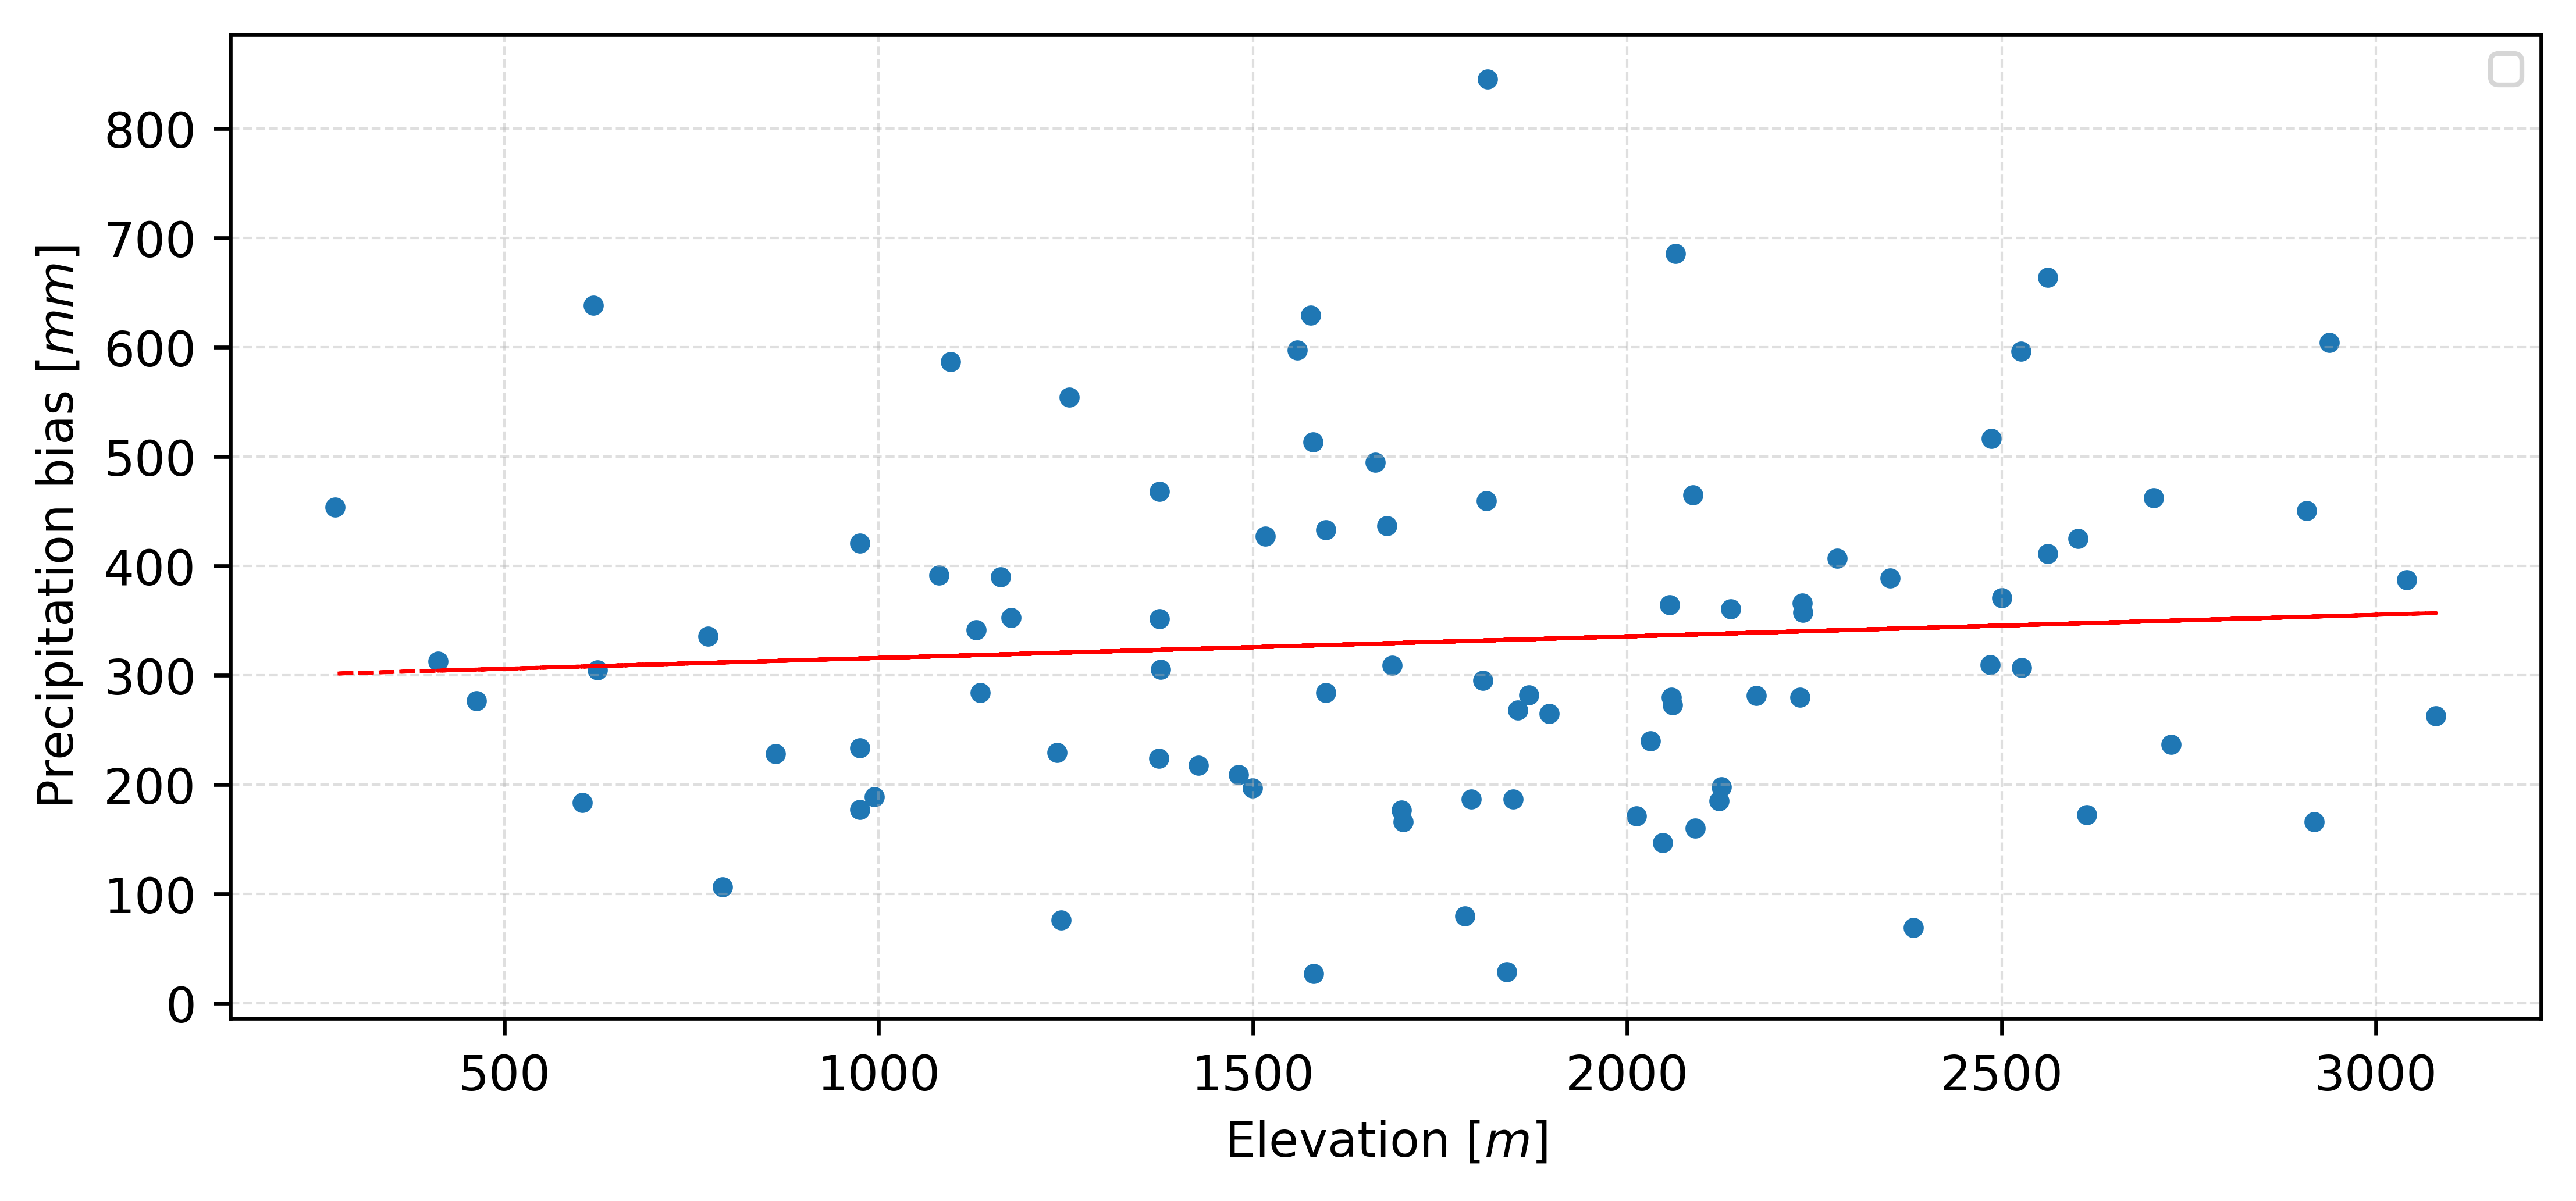

In [34]:
fig, axs = instantiatePlot( "Elevation $[m]$", "Precipitation bias $[mm]$" )

axs.scatter( data['elevation'], data['bias'], s=10 )

# import pingouin as pg
# mod = pg.linear_regression(data['elevation'],data['bias'])

z1 = np.polyfit( data['elevation'], data['bias'], 1 )
p1 = np.poly1d(z1)
axs.plot( np.array(data['elevation']), p1(data['elevation']), "r--" )

output_file = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/yearly/meteo_" + 'precipitation_AA_yearly_elevation_bias.' + output_format
mkNestedDir(getPathFromFilepath(output_file))
fig.savefig( output_file, format=output_format, bbox_inches='tight', facecolor='w', dpi=50 )

output_file_hd = current.config["output_path"] +  "meteo/" + basin_str + "/precipitation/" + "/yearly/meteo_" + 'precipitation_AA_yearly_elevation_bias_HD.' + output_format
mkNestedDir(getPathFromFilepath(output_file_hd))
fig.savefig( output_file_hd, format=output_format, bbox_inches='tight', facecolor='w', dpi=600 ) 

In [48]:
import pingouin as pg
mod = pg.linear_regression(data['elevation'], data['bias'])
mod.round(3)

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,296.115,49.867,5.938,0.000,0.007,-0.005,196.949,395.280
1,elevation,0.020,0.027,0.744,0.459,0.007,-0.005,-0.033,0.072


In [54]:
# pg.pairwise_corr(data, columns=['bias','elevation'])